# Mistral 7B Fine-Tuning
Now that our data is ready, we finetune Mistral 7B Instruct with QLora

In [ ]:
!pip install matplotlib
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets

In [ ]:
from datasets import load_dataset
from huggingface_hub import notebook_login
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

## Load Dataset and Model

In [ ]:
# Load Dataset
data = load_dataset("Giardooo/KG_constructor")
print(data)

Generating train split:   0%|          | 0/2400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['0'],
        num_rows: 2400
    })
    test: Dataset({
        features: ['0'],
        num_rows: 400
    })
})


In [ ]:
# Login to Hugginface
notebook_login()

In [ ]:
# Load Model
base_model_id = "mistralai/Mistral-7B-Instruct-v0.1"
bnb_config = BitsAndBytesConfig(
    # Load the 4 bit quantized model
    load_in_4bit=True,
    # Use nested quantization
    bnb_4bit_use_double_quant=True,
    # Define the quantization data type to NF4
    bnb_4bit_quant_type="nf4",
    # Set the computational type to bf16 for speed-up
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

## Set up the tokenizer

In [ ]:
# Set up tokenizer without max tokens
tokenizer = AutoTokenizer.from_pretrained(
    # Set up Mistral tokenizer
    base_model_id,
    # Since Mistral is decoder-only, left pad is preferred
    padding_side="left",
    # End Of Sequence token
    add_eos_token=True)

# Set pad token to unk_token
# The default pad_token = eos_token results in the LLM forgetting the appropriate usage of the eos token, making it never stop generating text
tokenizer.pad_token = tokenizer.unk_token

def tokenize(examples):
    # Extract the column of the dataset containing the text
    text = examples["0"]
    result = tokenizer(
        text,
        # truncation=True,
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
# Tokenize the dataset
tokenized_data = data.map(tokenize, batched=True)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

# Choose max_length
Let's check the length (in token) of our observations. In this way we are going to choose the max_length parameter of our tokenizer.

In [ ]:
import matplotlib.pyplot as plt

2800


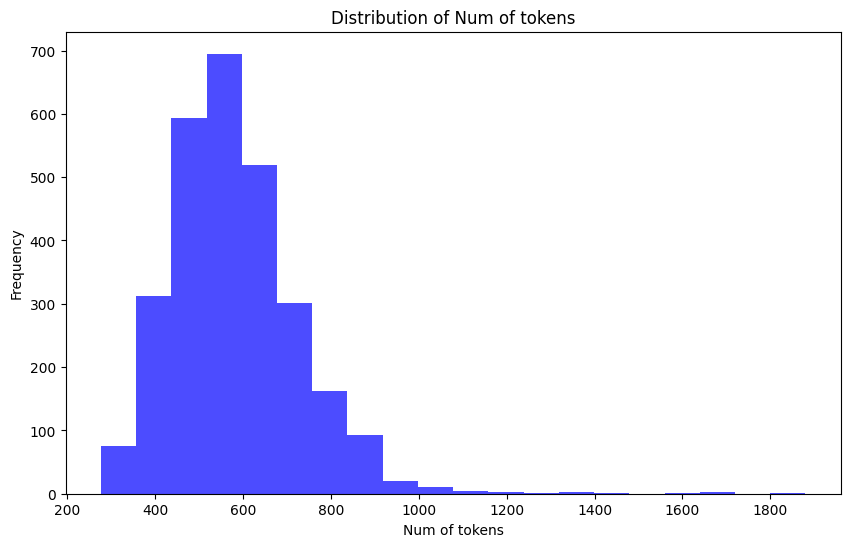

In [ ]:
def plot_data_lengths(train, val):
    lengths = [len(x['input_ids']) for x in train]
    lengths += [len(x['input_ids']) for x in val]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Num of tokens')
    plt.ylabel('Frequency')
    plt.title('Distribution of Num of tokens')
    plt.show()

plot_data_lengths(tokenized_data['train'], tokenized_data['test'])

1024 seems a reasonable max_length for our tokenizer.

In [ ]:
# Retokenize the data with a max length of 1024
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    model_max_length=1024,
    padding_side="left",)
#    add_eos_token=True)

tokenizer.pad_token = tokenizer.unk_token

def tokenize(examples):
    text = examples["0"]
    result = tokenizer(
        text,
        truncation=True,
        max_length=1024,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_data = data.map(tokenize, batched=True)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset = tokenized_data['train']
tokenized_val_dataset = tokenized_data['test']

In [ ]:
# Print an example of the tokenized_data
# The initial "0"s are the unk_token used for padding to the left.
# The ending "2" corresponds to the eos_token
print(tokenized_train_dataset[0]['input_ids'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# The max length has been correctly set to 1024
print(len(tokenized_train_dataset[0]['input_ids']))

1024


## Trying the base model
Let's try for the first time how the base Mistral 7B instruct performs with a casual observation.

In [ ]:
model_input = tokenized_train_dataset[0]['input_ids']

In [ ]:
eval_prompt = """[INST] Imagine being a Knowledge Graph constructor from unstructured text.
Following the schema provided, extract all the triples you can find in the text.

Schema:
(Legislator)-[REPRESENTS]->(StateCode)
(Legislator)-[IS_MEMBER_OF]->(Party)
(Legislator)-[ELECTED_TO]->(Body)
(BillId)-[SPONSORED_BY]->(Legislator)
(Legislator)-[VOTED_ON]->(BillId)
(BillId)-[REFERRED_TO]->(Committee)
(Legislator)-[SERVES_ON]->(Committee)
(BillId)-[DEALS_WITH]->(Subject)

Context:
"Hey guys, just wanted to share something I found out about the Tennessean and American Samoan representatives.
So, both Bob Corker and Chuck Fleischmann are from Tennessee. They're also both Republicans. That's cool! But here's the interesting part: Chuck Fleischmann is in the House, while Bob Corker isn't.
And guess what? The American Samoan representative, Amata Coleman Radewagen, is also a Republican. Plus, she's in the House too. Small world, huh?"[/INST]

Extracted Triples:"""

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    model_max_length=1024,
    padding_side="left")

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=False))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> [INST] Imagine being a Knowledge Graph constructor from unstructured text.
Following the schema provided, extract all the triples you can find in the text.

Schema:
(Legislator)-[REPRESENTS]->(StateCode)
(Legislator)-[IS_MEMBER_OF]->(Party)
(Legislator)-[ELECTED_TO]->(Body)
(BillId)-[SPONSORED_BY]->(Legislator)
(Legislator)-[VOTED_ON]->(BillId)
(BillId)-[REFERRED_TO]->(Committee)
(Legislator)-[SERVES_ON]->(Committee)
(BillId)-[DEALS_WITH]->(Subject)

Context:
"Hey guys, just wanted to share something I found out about the Tennessean and American Samoan representatives.
So, both Bob Corker and Chuck Fleischmann are from Tennessee. They're also both Republicans. That's cool! But here's the interesting part: Chuck Fleischmann is in the House, while Bob Corker isn't.
And guess what? The American Samoan representative, Amata Coleman Radewagen, is also a Republican. Plus, she's in the House too. Small world, huh?"[/INST]

Extracted Triples:
(BobCorker)-[REPRESENTS]->(Tennessee)
(ChuckFle

# Set up QLoRA

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
# Print the model
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNo

We will apply QLoRA to all the linear layers: `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [ ]:
# We will apply QLoRA to all the linear layers:
linear_layers = [
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
    "lm_head",
]

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules = linear_layers,
    #bias="none",
    lora_dropout=0.05,  # In QLoRa paper
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

In [ ]:
# How many trainable parameters do we have?
trainable_params = 0
all_param = 0
for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(
    f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
)

trainable params: 21260288 || all params: 3773331456 || trainable%: 0.5634354746703705


## Train the Model

In [ ]:
import transformers
from datetime import datetime

tokenizer.pad_token = tokenizer.unk_token

t_args = transformers.TrainingArguments(
    output_dir="Prova1",
    warmup_steps=5,
    per_device_train_batch_size=2,
    gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    max_steps=1000,
    learning_rate=2.5e-5, # Want about 10x smaller than the Mistral learning rate
    logging_steps=50,
    bf16=True,
    optim="paged_adamw_8bit",
    logging_dir="./logs",        # Directory for storing logs
    save_strategy="steps",       # Save the model checkpoint every logging step
    save_steps=50,                # Save checkpoints every 50 steps
    eval_strategy="steps", # Evaluate the model every logging step
    eval_steps=50               # Evaluate and save checkpoints every 50 steps
    #do_eval=True,                # Perform evaluation at the end of training
)

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args= t_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

# Silence the warnings
model.config.use_cache = False
trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(

Step,Training Loss,Validation Loss
50,0.986600,0.701309
100,0.658600,0.600361
150,0.569500,0.561125
200,0.576000,0.543309
250,0.546400,0.532739
300,0.527600,0.524735
350,0.498200,0.519283
400,0.502900,0.513471
450,0.483600,0.508509
500,0.489700,0.504467


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:204: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, tor

TrainOutput(global_step=1000, training_loss=0.5147548580169677, metrics={'train_runtime': 13883.8064, 'train_samples_per_second': 0.576, 'train_steps_per_second': 0.072, 'total_flos': 3.50548150714368e+17, 'train_loss': 0.5147548580169677, 'epoch': 3.3333333333333335})

# Fine-tuning for Few Shot prompting
We are now going to repeat the exact same operations, but using the dataset containing in its observations examples.

## Load Dataset and Model

In [ ]:
# Load Dataset
data = load_dataset("Giardooo/KG_constructor_FS")
print(data)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['0'],
        num_rows: 2400
    })
    test: Dataset({
        features: ['0'],
        num_rows: 400
    })
})


In [ ]:
# Login to Hugginface
notebook_login()

In [ ]:
# Load Model
base_model_id = "mistralai/Mistral-7B-Instruct-v0.1"
bnb_config = BitsAndBytesConfig(
    # Load the 4 bit quantized model
    load_in_4bit=True,
    # Use nested quantization
    bnb_4bit_use_double_quant=True,
    # Define the quantization data type to NF4
    bnb_4bit_quant_type="nf4",
    # Set the computational type to bf16 for speed-up
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

## Set up the tokenizer

In [ ]:
# Set up tokenizer without max tokens
tokenizer = AutoTokenizer.from_pretrained(
    # Set up Mistral tokenizer
    base_model_id,
    # Since Mistral is decoder-only, left pad is preferred
    padding_side="left",
    # End Of Sequence token
    add_eos_token=True)

# Set pad token to unk_token
# The default pad_token = eos_token results in the LLM forgetting the appropriate usage of the eos token, making it never stop generating text
tokenizer.pad_token = tokenizer.unk_token

def tokenize(examples):
    # Extract the column of the dataset containing the text
    text = examples["0"]
    result = tokenizer(
        text,
        # truncation=True,
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
# Tokenize the dataset
tokenized_data = data.map(tokenize, batched=True)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

# Choose max_length
Let's check the length (in token) of our observations. In this way we are going to choose the max_length parameter of our tokenizer.<br>
Of course, we expect that the length of our observatins is greater than before, since we added 3 examples in each of them

In [ ]:
import matplotlib.pyplot as plt

2800


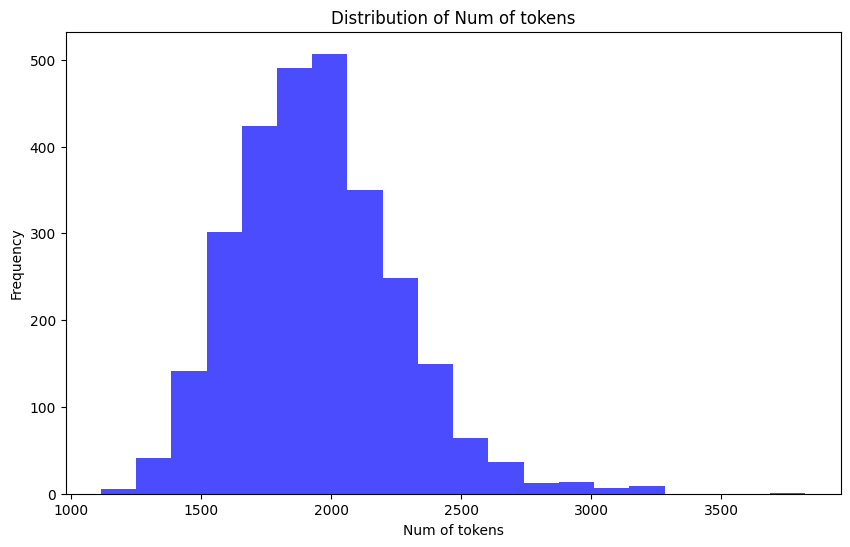

In [ ]:
def plot_data_lengths(train, val):
    lengths = [len(x['input_ids']) for x in train]
    lengths += [len(x['input_ids']) for x in val]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Num of tokens')
    plt.ylabel('Frequency')
    plt.title('Distribution of Num of tokens')
    plt.show()

plot_data_lengths(tokenized_data['train'], tokenized_data['test'])

As we expected, the observations got lengthier. Now, 3072 seems a reasonable max_length for our tokenizer.

In [ ]:
# Retokenize the data with a max length of 3072
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    model_max_length=3072,
    padding_side="left",)
#    add_eos_token=True)

tokenizer.pad_token = tokenizer.unk_token

def tokenize(examples):
    text = examples["0"]
    result = tokenizer(
        text,
        truncation=True,
        max_length=3072,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_data = data.map(tokenize, batched=True)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset = tokenized_data['train']
tokenized_val_dataset = tokenized_data['test']

In [ ]:
# Print an example of the tokenized_data
# The initial "0"s are the unk_token used for padding to the left.
# The ending "2" corresponds to the eos_token
print(tokenized_train_dataset[0]['input_ids'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# The max length has been correctly set to 3072
print(len(tokenized_train_dataset[0]['input_ids']))

3072


# Set up QLoRA
These are exactly the same cells.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
# Print the model
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((

We will apply QLoRA to all the linear layers: `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [ ]:
# We will apply QLoRA to all the linear layers:
linear_layers = [
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
    "lm_head",
]

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules = linear_layers,
    #bias="none",
    lora_dropout=0.05,  # In QLoRa paper
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

In [ ]:
# How many trainable parameters do we have?
trainable_params = 0
all_param = 0
for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(
    f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
)

trainable params: 21260288 || all params: 3773331456 || trainable%: 0.5634354746703705


## Train the Model

In [ ]:
import transformers
from datetime import datetime

tokenizer.pad_token = tokenizer.unk_token

t_args = transformers.TrainingArguments(
    output_dir="Prova_FS",
    warmup_steps=5,
    per_device_train_batch_size=2,
    gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    max_steps=1000,
    learning_rate=2.5e-5, # Want about 10x smaller than the Mistral learning rate
    logging_steps=50,
    bf16=True,
    optim="paged_adamw_8bit",
    logging_dir="./logs",        # Directory for storing logs
    save_strategy="steps",       # Save the model checkpoint every logging step
    save_steps=50,                # Save checkpoints every 50 steps
    eval_strategy="steps", # Evaluate the model every logging step
    eval_steps=50               # Evaluate and save checkpoints every 50 steps
    #do_eval=True,                # Perform evaluation at the end of training
)

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args= t_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

# Silence the warnings
model.config.use_cache = False
trainer.train()

max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
50,0.942300,0.778176
100,0.712600,0.675742
150,0.640500,0.647505
200,0.606800,0.622850
250,0.567800,0.605893
300,0.533300,0.595291
350,0.484800,0.599950
400,0.460800,0.600457


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

KeyboardInterrupt: 

The error you see are given by the fact that I manually interrupted the training as the model began overfitting.<br>
Furthermore, as you can see, the training of a model with these lengthier observations requires way more time (40 minutes for each 50 steps), and I do not have the resources to train it till the end.